In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from torch.utils.data import DataLoader, TensorDataset

np.random.seed(1337)

# Load and process the data
aggregate_df1 = pd.read_csv('/home/awinlab/Documents/kevin/elec110.csv', index_col='datetime', parse_dates=True)
aggregate_df1 = aggregate_df1[:900000]

plug1_1 = pd.read_csv('/home/awinlab/Documents/kevin/plug1-1.csv', index_col='datetime', parse_dates=True)
plug1_1 = plug1_1[:900000]

aggregate_df1 = aggregate_df1.drop(['Unnamed: 0','id','device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'], axis=1)
plug1_1 = plug1_1.drop(['Unnamed: 0','id','device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'], axis=1)

/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, length=100):
        self.X = X
        self.y = y
        self.length = length

    def __len__(self):
        return len(self.X) - self.length

    def __getitem__(self, idx):
        X = self.X[idx: idx + self.length]
        y = self.y[idx: idx + self.length]
        return X, y

mask = [i % 5 != 0 for i in range(len(aggregate_df1))]
X_train = aggregate_df1[~np.array(mask)]
X_test = aggregate_df1[mask]



mask1 = [i % 5 != 0 for i in range(len(plug1_1))]
y_train = plug1_1[~np.array(mask1)]
y_test = plug1_1[mask1]

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


X_train = torch.tensor(X_train.values).float()
X_test = torch.tensor(X_test.values).float()
y_train = torch.tensor(y_train.values).float()
y_test = torch.tensor(y_test.values).float()


In [4]:
batch_size=60

train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers = 0, drop_last = True, 
                                           collate_fn=lambda x: (torch.nn.utils.rnn.pad_sequence([i[0] for i in x], batch_first=True),
                                                                 torch.nn.utils.rnn.pad_sequence([i[1] for i in x], batch_first=True)))

test_dataset = TimeSeriesDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers = 0, drop_last = True,
                                           collate_fn=lambda x: (torch.nn.utils.rnn.pad_sequence([i[0] for i in x], batch_first=True),
                                                                 torch.nn.utils.rnn.pad_sequence([i[1] for i in x], batch_first=True)))

In [5]:
import torch.nn.functional as F
from torch.nn import L1Loss

class sgn_branch_network(nn.Module):
    def __init__(self, mains_length, appliance_length):
        super(sgn_branch_network, self).__init__()
        self.mains_length = mains_length
        self.appliance_length = appliance_length
        
        self.conv = nn.Sequential(
            nn.ConstantPad1d((4, 5), 0),
            nn.Conv1d(100, 30, 10, stride = 1),
            nn.ReLU(True),
            nn.ConstantPad1d((3, 4), 0),
            nn.Conv1d(30, 30, 8, stride = 1),
            nn.ReLU(True),
            nn.ConstantPad1d((2, 3), 0),
            nn.Conv1d(30, 40, 6, stride = 1),
            nn.ReLU(True),
            nn.ConstantPad1d((2, 2), 0),
            nn.Conv1d(40, 50, 5, stride = 1),
            nn.ReLU(True),
            nn.ConstantPad1d((2, 2), 0),
            nn.Conv1d(50, 50, 5, stride = 1),
            nn.ReLU(True)
        )
        self.dense = nn.Sequential(
            nn.Linear(50 , 1024),
            nn.ReLU(True),
            nn.Linear(1024, 100)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.dense(x.view(x.size(0), -1))
        return x


class sgn_Pytorch(nn.Module):
    def __init__(self, mains_length, appliance_length):
        # Refer to "SHIN C, JOO S, YIM J. Subtask Gated Networks for Non-Intrusive Load Monitoring[J]. Proceedings of the AAAI Conference on Artificial Intelligence."
        super(sgn_Pytorch, self).__init__()
        self.gate = sgn_branch_network(mains_length, appliance_length)
        self.reg = sgn_branch_network(mains_length, appliance_length)
        self.act = nn.Sigmoid()
        self.b = nn.parameter.Parameter(torch.zeros(1))

    def forward(self, x):
        reg_power = self.reg(x)
        app_state = self.act(self.gate(x))
        app_power = reg_power * app_state + (1 - app_state) * self.b
        return app_power, app_state
    
n_input = 100
input_shape = (n_input, 1)
model = sgn_Pytorch(60, n_input)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)
mae_fn = nn.L1Loss()

model = model.to(device)
loss_fn = loss_fn.to(device)
mae_fn = mae_fn.to(device)

In [6]:
def rete(y_true, y_pred):
    y_true = y_true.view(-1, 1)
    y_pred = y_pred.view(-1, 1)

    # Compute the maximum value between y_true and y_pred element-wise, and reshape it to have shape (batch_size*seq_len, 1)
    max_val, _ = torch.max(torch.cat([y_pred, y_true], dim=1), dim=1, keepdim=True)

    # Compute the relative error between y_true and y_pred element-wise, and reshape it to have shape (batch_size*seq_len, 1)
    rel_err = torch.abs(y_pred - y_true) / max_val

    # Take the mean of the relative error across all samples in the batch
    return torch.mean(rel_err)

In [7]:
import matplotlib.pyplot as plt
import tqdm

num_epochs = 5

for epoch in range(num_epochs):
    for i, (X_batch, y_batch) in enumerate(tqdm.tqdm(train_loader)):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred1, y_pred2 = model(X_batch) 
        batch_size, sequence_length, output_size = y_batch.shape
        y_batch = y_batch.reshape(batch_size * sequence_length, output_size)
        y_pred1 = y_pred1.reshape(batch_size * sequence_length, 1)
        loss = loss_fn(y_pred1, y_batch)
        mae = mae_fn(y_pred1, y_batch)
        rete_val = rete(y_batch[:, 0], y_pred1.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    tqdm.tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item()}, MAE: {mae.item()}, Rete: {rete_val.item()}")



100%|██████████| 2998/2998 [00:28<00:00, 103.91it/s]


Epoch [1/5], Step [2997/2998], Loss: 0.09007968753576279, MAE: 0.19034597277641296, Rete: 0.022915521636605263


100%|██████████| 2998/2998 [00:28<00:00, 105.35it/s]


Epoch [2/5], Step [2997/2998], Loss: 0.07988070696592331, MAE: 0.16253486275672913, Rete: 0.019460923969745636


100%|██████████| 2998/2998 [00:28<00:00, 104.81it/s]


Epoch [3/5], Step [2997/2998], Loss: 0.07886478304862976, MAE: 0.1604192852973938, Rete: 0.019198158755898476


100%|██████████| 2998/2998 [00:28<00:00, 105.90it/s]


Epoch [4/5], Step [2997/2998], Loss: 0.08110162615776062, MAE: 0.16806785762310028, Rete: 0.02014833129942417


100%|██████████| 2998/2998 [00:28<00:00, 105.09it/s]

Epoch [5/5], Step [2997/2998], Loss: 0.07470949739217758, MAE: 0.14842084050178528, Rete: 0.017707694321870804


In [8]:
predict = []
model = model.cpu()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predict.append(torch.tensor(outputs[0][:, 0].unsqueeze(1)))  # 轉換為張量
predict = torch.cat(predict, dim=0)
predict_list = np.concatenate([p.detach().numpy() for p in predict], axis=0)

/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [9]:
predict_list.shape

(719880,)

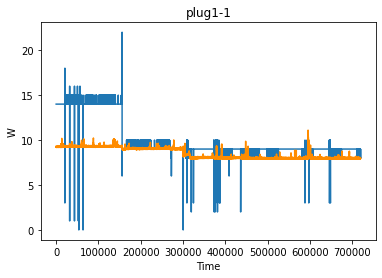

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(facecolor='white')
plt.plot(y_test)
plt.plot(predict_list,color='darkorange')
plt.xlabel('Time')
plt.ylabel("W")
plt.title("plug1-1")
plt.savefig('/home/awinlab/Documents/kevin/SGN/pytorch/SGN_plug1-1.png')
plt.show()